# Predicting Emissions Of Buildings In NYC
------

## Contents

__[1. Predictive Models For Green House Gas Emission ](#fourth-bullet)__

- __[Linear Regression ](#model-one)__

- __[General Additive Models](#model-two)__

- __[Gradient Boosted Regression Trees](#model-three)__

__[2. Conclusions And Recommendations ](#fifth-bullet)__


--------------

## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
I started this project a while back with a goal of taking the 2016 NYC Benchmarking Law data about building energy usage and do something interesting with it. I originally attmpted to clean and analyze this data set to try to find ways to reduce builings' energy usage and subsequently their green house gas emissions. After a few iterations I thought it might be interesting to see if we could additonally predict the emission of green house gases from buildings by looking at their age, energy and water consumption as well as other energy consumption metrics. In the modeling section we look at three different modes for predicting green house gas emissions:

1. Linear Regression

2. Generalized Additive Models

3. Gradient Boosted Regression Trees

In the conclusion section I not only summarize the findings, but give some specific recommendations to reduce the multi-family buildings energy usage.

----------
### Data 
----------
The NYC Benchmarking Law requires owners of large buildings to annually measure their energy and water consumption in a process called benchmarking. The law standardizes this process by requiring building owners to enter their annual energy and water use in the U.S. Environmental Protection Agency's (EPA) online tool, ENERGY STAR Portfolio Manager® and use the tool to submit data to the City. This data gives building owners about a building's energy and water consumption compared to similar buildings, and tracks progress year over year to help in energy efficiency planning.  In this blog post we will analyze how buildings in New York City use energy and water, make recommendations on how to improve their performance and also model their green house gas emissions. The source code for this project can be found <a href="https://github.com/mdh266/NYCBuildingEnergyUse">here</a>.


Benchmarking data is also disclosed publicly and can be found <a href="http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml">here</a>.  I analyzed the 2016 data and my summary of the findings and recommendations for reducing energy consumption in New York City buildings are discussed in the conclusions section.

The 2016 data is very messy and a lot of cleaning was necessary to do analysis on it.  One thing to note is that this is **self-reported data**, meaning the performance data wasn't collected by a non-bias third party but by the building owners.  This means our data is biased and we will keep this in mind while performing our analysis.

There are about 13,223 buildings recorded in this dataset and many of them have missing data values. While there are many different techniques for imputing missing values, there was sufficient number of buildings with all their values that I did not need to impute missing values. The cleaning process was made more difficult because the data was stored as strings with multiple non-numeric values which made converting the data to its proper type a more involved process.

--------------------------
## Exploratory Analysis<a class="anchor" id="second-bullet"></a>
-------------------------
Since the cleaning was more tedious I created external functions do handle this processes.  In addition, I also a created functions to handle transforming and plotting the data.  I kept these functions in seperate files <code>Cleaning_Functions.py</code> and <code>Plotting_Functions.py</code> respecively so as to not clutter the post.  We import these functions along with other basic libraries (<a href="http://pandas.pydata.org/">Pandas</a>, <a href="http://matplotlib.org/">Matplotlib</a> and <a href="http://seaborn.pydata.org/">Seaborn</a>) as well as read in the data file below:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Predictive Models For Green House Gas Emissions <a class="anchor" id="fourth-bullet"></a>

Now let's build a predictive model for green house gas Emissions by multifamily homes in New York City.  We'll do this at first using a simple linear regression model.  While not the best in terms of perdictive performance it is often a best first step since it allows one to interpet the effect each feature has on the predicted green house gas emissions.  

Before building a model, we first have to prepare our features and scale them appropriately. This involves dictating which are the continuous variabels and the categorical variables.  We define them as,

In [2]:
df = pd.read_csv("data/data.csv")

In [3]:
df2 = df.dropna()

In [4]:
df2.head()

,Zip_Code,Year_Built,Energy_Star,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI,GHGI,OPSFT,Age
0,10019,1950,79.0,51.3,1437732.8,1507302.8,201.4,768.5,24.430049,25.612187,0.013058,0.003422,0.001614,67.0
1,10021,1964,80.0,44.9,2739020.0,4737201.3,538.4,11901.5,16.457292,28.463284,0.071510,0.003235,0.000571,53.0
2,10128,1960,10.0,91.3,5733933.4,4759700.8,699.3,7455.1,49.886752,41.410668,0.064861,0.006084,0.000827,57.0
3,10280,1988,7.0,100.0,11837980.8,10677919.2,1514.3,15597.6,49.892447,45.003242,0.065738,0.006382,0.000421,29.0
4,10280,1988,14.0,119.1,11913419.6,5901391.6,1122.2,11638.6,62.943048,31.179257,0.061491,0.005929,0.000528,29.0


In [28]:
continuous_vars  = ["NGI", "EI", "WI", "GHGI", "OPSFT",
                    "Site_EUI","Year_Built", "Energy_Star"]

df_cont          = df2[continuous_vars]

# df_cat           = pd.get_dummies(df2["Zip_Code"].astype(str), 
#                                   prefix="zip", 
#                                   dummy_na=False)



# df_comb          = df_cont.merge(df_cat,
#                                  left_index=True,
#                                  right_index=True)



In [51]:
X,Y = df_cont.drop(["GHGI","Site_EUI"],axis=1), df_comb["GHGI"]

In [52]:
X.shape

(4407, 6)

In [53]:
X.head()

,NGI,EI,WI,OPSFT,Year_Built,Energy_Star
0,24.430049,25.612187,0.013058,0.001614,1950,79.0
1,16.457292,28.463284,0.071510,0.000571,1964,80.0
2,49.886752,41.410668,0.064861,0.000827,1960,10.0
3,49.892447,45.003242,0.065738,0.000421,1988,7.0
4,62.943048,31.179257,0.061491,0.000528,1988,14.0


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_s  = scaler.transform(X_train)
X_test_s   = scaler.transform(X_test)

In [57]:
import mlflow
import mlflow.sklearn


### Linear Regression <a class="anchor" id="model-one"></a>

As we stated early we'll start out with a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression Model</a> since it is simple and interpertable. The form of a linear regression the model assumes that the green hour gas emission intensity (`GHGI`) labeld $y$, can be expressed a linear combination,

$$ y \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} + \epsilon$$


The $x_{i}$'s are the features for our model (`WI`, `OPSFT`, etc), and the error $\epsilon \sim N(0,\sigma^{2}$) is normally distributed.  We then make a model $h_{\theta}(\textbf{x})$,

$$ h_{\theta}(\textbf{x}) \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

And estimate the coefficents ($\theta_{i}$) are estimated using ordinary least squares methods.  This leads to the expected value of our preditions being unbiased:

$$ E[ h_{\theta}(\textbf{x})] \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

We can easily implement a least squares regression model using Scikit-learn:

In [58]:
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import r2_score

# mlflow.create_experiment(name      = "Linear Regression")

reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

We can then evaluate the model performance ($R^{2}$-score) on the test set to *see how much variance in the model we are able to explain,*

In [59]:
y_pred = reg.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))

Variance score: 0.0015814222871456396


In [60]:
y_pred = reg.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))


Variance score: 0.0015814222871456396


In [ ]:
mflow.star

We can explain 53% of the variance which definitely leaves room for improvement, but we expected that such a simple model would not perform well.  Let's take a look at which features are most important.

In [39]:
for coef in zip(X_train.columns, reg.coef_):
    print(coef)

('NGI', 5.309628283585589e-05)
('EI', 8.227177858250337e-05)
('WI', 0.0006856555231852222)
('OPSFT', -1.5911725065980136)
('Year_Built', -9.28960926349405e-05)
('Energy_Star', -0.0002334188589969549)


For features that have continuous values the model coefficents tell us that an increase on of their in units results in an incrase in the unit of green house emissions tha is equal to the coefficent.  We can see that increasing the electricty, water intensity and occupancy increase the green house gas emissions, which makes sense. *However, increases in natural gas intensity usage decreases the green house gas emisssions.*  This is strange, however, it could also be because of multi-collinarity of the features. 

Additionally, I'm not sure how green house gas emissions are calculated, if the calculations include the emissions from power sources this could make sense since electricity often comes from coal which releases more emissions that using natural gas.  Therefore switching to natural gas instead of electricity could reduce green house gas emissions. 


We can measure the p-values for coefficents by using Scikit-Learns's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html">f_regression</a> function.

In [40]:
from sklearn.feature_selection import f_regression

f_stats, pvals = f_regression(X_train, y_train)

for coef in zip(X_train.columns, pvals):
    print("{0}'s p-value : {1}".format(coef[0],coef[1]))

NGI's p-value : 0.0
EI's p-value : 8.444013848209199e-07
WI's p-value : 0.9450349473437867
OPSFT's p-value : 0.6453206108849399
Year_Built's p-value : 0.06618011833652522
Energy_Star's p-value : 0.0038616403718772807


**We see that even though the coeficients of the regression model are rather small, their small p-values signifiy that they are still signifcant and should be included in our model.**

Let's look at some of the residuals in the continuous features to see if we can find any non-linear patterns that might signal ways improve the model.

/Users/mukeharmon/miniconda/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


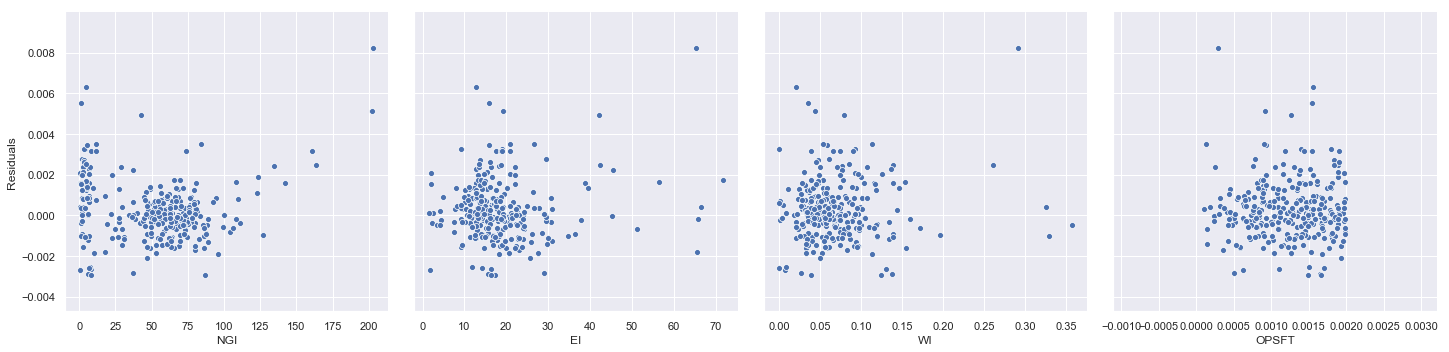

In [59]:
# compute the residuals
resid = (y_test - y_pred).to_frame()\
                         .rename(columns={"GHGI":"Residuals"})

# left join them to the original features
x_resid = X_test.merge(resid, left_index=True, right_index=True)

# plot the residuals
sns.pairplot(x_resid, 
             x_vars=['NGI','EI','WI','OPSFT'], 
             y_vars='Residuals', 
             kind = 'scatter',
             size=5, 
             dropna=True)

A slightly parabolic pattern in the `WI`'s residuals, but nothing to clear in the others. One way we could improve our model's $R^{2}$ value is to tune the regularization parameter however, let's move on to a more flexible model and hopefully improve our predictions.

### Generalized Additive Models <a class="anchor" id="model-two"></a>

Linear regression is a specific type of generalized linear model.  <a href="https://en.wikipedia.org/wiki/Generalized_linear_model">Generalized lienar models</a> relate the expected outcome of the target variable, $y$, to the model's features $x_{1}, x_{2}, \ldots x_{p}$ through the equation:

$$ g(E[h_{\theta}(\textbf{x})]) \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

The function $g$ is called the **link** function. For linear regresion the link function is just the identity function, while for logistic regression it is the <a href="https://en.wikipedia.org/wiki/Logit">logit function</a>.

<a href="https://en.wikipedia.org/wiki/Generalized_additive_model">Generalized Additive Models </a>are extension of the generalized addative model that assume that the expected outcome of the target variable $y$ to the features $x_{1}, x_{2}, \ldots x_{p}$ through the equation:

$$ g(E[h_{\theta}(\textbf{x})]) \; = \; \theta_{0} + f_{1}(x_{1}) + f_{2}(x_{2}) +  \ldots + f_{p}(x_{p}) $$

The basis functions $f_{i}$ can be functions of a parameteric form such as a polynomial, or more general non-parametric functions.  Using basis functions allows for smoother, higher order (more accurate) approximations to the model in parameter space when compared to traditional polynomials.  GAMs therefore allow for more accurate predictions than generalized linear models, however, they still allowing for the model to be interperable.  

We'll use the <a href="https://github.com/dswah/pyGAM">PyGam</a> library which uses penalized <a href="https://en.wikipedia.org/wiki/B-spline">B splines</a> as basis functions. This choice of basis functions allow us to automatically model non-linear relationships without having to manually try out many different transformations on each variable.

We can import the regression GAM model:

In [61]:
from pygam import LinearGAM

We can then fit our model using 10 splines and using a grid search:

In [62]:
gam = LinearGAM(n_splines=10).fit(X_train, y_train)

PyGam gives a summary report of our model similar to the <a href="http://www.statsmodels.org/stable/index.html">StatsModels</a> library:

In [63]:
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.9894
Link Function:                     IdentityLink Log Likelihood:                               -146500.3623
Number of Samples:                         3525 AIC:                                           293058.7034
                                                AICc:                                          293059.2009
                                                GCV:                                                0.0111
                                                Scale:                                               0.011
                                                Pseudo R-Squared:                                   0.9758
Feature Function                  Lam

Evaluating the performance of our model on the test set we find an $R^{2}$ score of:

In [64]:
y_pred = gam.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))

Variance score: 0.027752347623785534


The GAM model results in an improvement in the $R^2$ score!  We can see that using a more flexible model like a GAM using B-splines is better able to explain the variance in our data when compared to a linear regression model.

We can explore the effect that the number of splines used in our model has on the performance by training the model on various numbers of splines and plotting the learning curves.  We write a function to train a model and returns 1 - $R^2$ on the training and test set respectively.

In [65]:
def train_gam_full(X_train, y_train, X_test, y_test, n_splines):
    """
    Trains a linear GAM model and returns performance on training and test sets.
    
    :parameters:
    -----------
    X_train (DataFrame) : Training set of features
    y_train (Series)    : Training set target values
    X_test (DataFrame)  : Test set of features
    y_test (Series)     : Test set target values
    n_splines (int)     : The number of splines to use in the GAM
    
    :returns: 
    --------
    The tupple of (1-R^2) for the training and test set respectively.
    
    """
    model   = LinearGAM(n_splines=n_splines).fit(X_train, y_train)
    y_pred  = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    
    return 1-r2_score(y_train, y_pred), 1-r2_score(y_test, y_pred2)

We now get the results for our model's learning curve using ideas from functional programing. 

We transform the above function into one that is only dependent on the number of splines using the <a href="https://docs.python.org/2/library/functools.html">partial</a> tool to bind the values the training and test set.  This will allow us to return a function that returns 1 - $R^2$ on the training and test set and only depends on the number of splines.

In [66]:
from functools import partial
train_gam = partial(train_gam_full, X_train, y_train, X_test, y_test)

Now we can define the number of spines we want to train on and then use the <a href="http://book.pythontips.com/en/latest/map_filter.html">map</a> function to get the performance metrics and plot the resulting learning curves:

In [67]:
# defined the 
n_splines = range(5,21)

# get the r2 values
r2_train, r2_test = zip(*map(train_gam, n_splines))

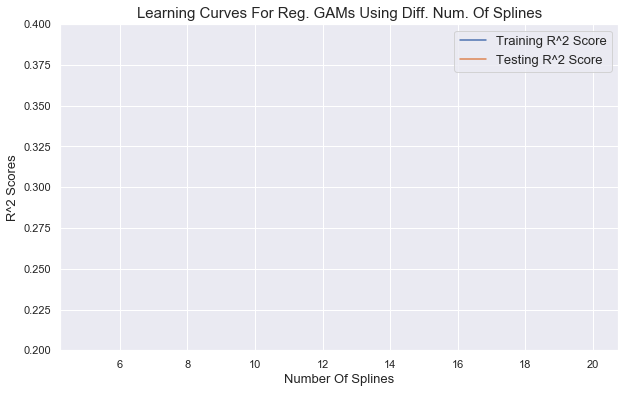

In [68]:
# plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(n_splines, r2_train, label="Training R^2 Score")
plt.plot(n_splines, r2_test,  label="Testing R^2 Score")
plt.ylabel("R^2 Scores",fontsize=13)
plt.xlabel("Number Of Splines",fontsize=13)
plt.ylim([0.2,0.4])
plt.title("Learning Curves For Reg. GAMs Using Diff. Num. Of Splines", fontsize=15)
plt.legend(fontsize=13)

We can see that increasing the number of splines doesnt seem to improve the predictive performance of the model past 10 or 12 splines.  


So in order to improve the predictive ability we'll need to turn to a different model.

###  Gradient Boosted Regression Trees <a class="anchor" id="model-three"></a>

Let's try another model to see if we cant improve our $R^2$ score for our model.  One model that performs quite well is the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">Gradient Boosted Regression Tree</a>.  It is a nonlinear model based on decision trees and is one of the best performing machine learning models avaiable. We can use Scikit-learns gradient boosted regressor:

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

GBR = GradientBoostingRegressor()

Now let's run a grid search using cross-valiation to find the optimal parameter values for our model:

In [17]:
# define the parameter values
paramters = {"n_estimators":[50,100],# 125,150,200],
             "max_depth"   :[3,5,7], 
             "loss"        :["ls", "lad"],#, "huber", "quantile"]
            }

# defind the grid search and optimization metric
grid = GridSearchCV(estimator=GBR,
                    param_grid=paramters,
                    scoring="r2",
                    cv=5,
                    n_jobs=-1)

# perform the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'loss': ['ls', 'lad']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

Now that we have the best model from our grid search over the trainin set let see how it performs on the test set:

In [18]:
y_pred = grid.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(y_test, y_pred)))

Variance score: 0.7778492717292838


Again a definite improvement in the $R^2$ score!  While we have improved our prediction capabilities, one draw back to more complex models like Gradient Boosted Regressors is that they are less interperable.  Despite this draw back, Scikit-learn still allows to the find the relative importance of the features on the outcome of the model:

In [20]:
model = grid.best_estimator_
for coef in zip(X_train.columns, model.feature_importances_):
    print(coef)

('NGI', 0.28306335291396933)
('EI', 0.07276454147383107)
('WI', 0.06815610343205734)
('OPSFT', 0.03443697921229804)
('Year_Built', 0.00977433651564942)
('Energy_Star', 0.49933096209039823)
('zip_10001.0', 7.366138738114959e-05)
('zip_10002.0', 0.0012153327155546027)
('zip_10003.0', 0.00039238188578971504)
('zip_10004.0', 2.599725523026836e-05)
('zip_10005.0', 5.069870770011958e-05)
('zip_10006.0', 0.000627879501378974)
('zip_10007.0', 0.00011492019805470444)
('zip_10009.0', 0.00021745128599511964)
('zip_10010.0', 0.0)
('zip_10011.0', 0.0003406905085313891)
('zip_10012.0', 5.574555109402042e-05)
('zip_10013.0', 0.000231048152138146)
('zip_10014.0', 0.0012009856421270164)
('zip_10016.0', 0.0)
('zip_10017.0', 0.0010026051410823523)
('zip_10018.0', 0.0)
('zip_10019.0', 0.004134542685411771)
('zip_10021.0', 0.000326384306392943)
('zip_10022.0', 0.003747722198558782)
('zip_10023.0', 0.0005643016756056744)
('zip_10024.0', 0.006264734380763231)
('zip_10025.0', 0.0019262065986694404)
('zip_1002

In [44]:
grid.__dir__()

['scoring',
 'estimator',
 'n_jobs',
 'fit_params',
 'iid',
 'refit',
 'cv',
 'verbose',
 'pre_dispatch',
 'error_score',
 'return_train_score',
 'param_grid',
 'multimetric_',
 'best_index_',
 'best_params_',
 'best_score_',
 'best_estimator_',
 'refit_time_',
 'scorer_',
 'cv_results_',
 'n_splits_',
 '__module__',
 '__doc__',
 '__init__',
 '_run_search',
 '__abstractmethods__',
 '_abc_registry',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_estimator_type',
 'score',
 '_check_is_fitted',
 'predict',
 'predict_proba',
 'predict_log_proba',
 'decision_function',
 'transform',
 'inverse_transform',
 'classes_',
 'fit',
 '_format_results',
 '_get_param_names',
 'get_params',
 'set_params',
 '__repr__',
 '__getstate__',
 '__setstate__',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subcl

[{'loss': 'ls', 'max_depth': 3, 'n_estimators': 50},
 {'loss': 'ls', 'max_depth': 3, 'n_estimators': 100},
 {'loss': 'ls', 'max_depth': 5, 'n_estimators': 50},
 {'loss': 'ls', 'max_depth': 5, 'n_estimators': 100},
 {'loss': 'ls', 'max_depth': 7, 'n_estimators': 50},
 {'loss': 'ls', 'max_depth': 7, 'n_estimators': 100},
 {'loss': 'lad', 'max_depth': 3, 'n_estimators': 50},
 {'loss': 'lad', 'max_depth': 3, 'n_estimators': 100},
 {'loss': 'lad', 'max_depth': 5, 'n_estimators': 50},
 {'loss': 'lad', 'max_depth': 5, 'n_estimators': 100},
 {'loss': 'lad', 'max_depth': 7, 'n_estimators': 50},
 {'loss': 'lad', 'max_depth': 7, 'n_estimators': 100}]

In [35]:


tups = [{k,v} for v in grid.cv_results_['mean_train_score']]

In [60]:
with mlflow.start_run():
    for params, metric in zip(grid.cv_results_['params'],grid.cv_results_['mean_train_score']):
        mlflow.log_params(params)
        mlflow.log_param("scoring",grid.scoring)
        mlflow.log_param("r2_score",metric)

    mlflow.sklearn.log_model(model,"model")


In [21]:
with mlflow.start_run():
    mlflow.log_param("alpha", model.alpha)
    mlflow.log_param("learning_rate", model.learning_rate)
    mlflow.log_param("n_estimators", model.n_estimators)
    mlflow.log_param("min_samples_leaf", model.min_samples_leaf)
    mlflow.log_param("criterion", model.criterion)
    mlflow.log_param("min_samples_leaf", model.min_samples_leaf)
    mlflow.log_metric("r2_score",r2_score(y_test, y_pred))
    mlflow.sklearn.log_model(model, 
                             conda_env="environment.yml",
                             "model")

The most important features for predicting green house gas emissions are the energy star score followed by tnatural gas intensity and the electicity intensity.  The zipcode and the year built have the least importance, which from our analysis above makes sense.

That's enough modeling for now! Overall we were able to come with a model that explains over 75% of the variance in the test set data.  Not bad!

--------------
## Conclusion And Recommendations <a class="anchor" id="fifth-bullet"></a>
--------------

In this blog post we analyzed the energy usage of multifamily buildings and developed a predictive model for these buildings green house gas emissions.  From the final heat map of the correlation matrix we can see that the Energy Star score is negatively correlated with enery usage intensity.  This makes sense as the energy star score is a measure of energy efficiceny of the building.  The energy usage intensity has a strong positive correlation to the natural gas usage intensity.  We can see that natural gas usage intensity and electricity usage intensity are uncorrlated.  This implies we could replace one with the other.  Therefore reducing natural gas consumption or replacing it with electricity could be the best answer to reducing energy usage intensity and green house gas emissions.  It should also be noted that year the residence was built did not have any correlation with energy usage intensity. This is probably due to the fact that the majority of residential buildings in New York City were built in a similar time period and before energy efficiency was a priority.


Since natural gas usage intensity is most highly correlated with energy usage intensity reducing it could improve building energy efficiency and reduce green house gas emissions (so long as the buildings' electricity comes from a clean energy source or atleast one with less emissions than natural gas). Some ways to reduce natural gas consumption include:

- Investing in more efficient heating and cooling services or slightly reducing the usage of either heating or cooling during the day when most people are not home. This is especially important in large buildings as HVAC systems have a larger volume of air to heat/cool.


- Another option is to reuse waste heat, such as reusing the vented air from electric clothes dryers, however, filtering and the air will be necessary and could alter the cost effectiveness of this approach.


- Replacing gas powered appliances such as stoves with more efficient electric ones is another option.  However, the source of electric power should also be considered to weigh the overall energy efficiency and enviromental impact.


- Another option is to replace gas powered water heaters by solar powered water heaters. While solar powered water heaters are not as cost effective in moderate climates, the presence of numerous roof top water tanks on New York City buildings may help make this option more financially competitive.  At the very least, it suggests that having roof top water tanks for solar powered water heaters is structurally possible, where as with individual houses this may not be the feasible.


- In addition, buying energy efficient refrigerators and dryers is also important as these are two of the largest energy consumers in ones home.


In addition, we investigated creating a predictive model of green house gas emissions for multi-family buildings in New York City.  The highest performing model was a gradient boosted tree model that had $R^2$ value of 0.76.  The most important features for predicting green house gas emissions in this model are the natural gas intensity followed by the energy start scored and the electicity intensity. The zipcode and the year built have the least importance, which from our analysis above makes sense.